<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Face Recognition Dataset:</font></span></h4>.

<a id="import"></a>
<h2><b><span style="color:#005f26">🔶 Step 1 | </span><span style="color:#ff6200">Import Libraries</span></b></h2>

In [1]:
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 2 | </span><span style="color:#ff6200">Reading Data</span></b></h2>

In [2]:
dataset_path = '/kaggle/input/face-recognition-dataset/Faces/Faces'
output_path = '/kaggle/working/organized_faces'

if not os.path.exists(output_path):
    os.makedirs(output_path)

for image_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_name)

    if os.path.isfile(image_path):
        class_name = image_name.split('_')[0]
        class_dir = os.path.join(output_path, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        dest_path = os.path.join(class_dir, image_name)

        with open(image_path, 'rb') as src_file, open(dest_path, 'wb') as dst_file:
            shutil.copyfileobj(src_file, dst_file)

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ At first,how many image in each class 
    </p>
</div>

Total number of classes: 31
Class "Camila Cabello": 87 images
Class "Hugh Jackman": 112 images
Class "Marmik": 32 images
Class "Brad Pitt": 120 images
Class "Akshay Kumar": 50 images
Class "Alia Bhatt": 79 images
Class "Kashyap": 30 images
Class "Billie Eilish": 98 images
Class "Lisa Kudrow": 70 images
Class "Zac Efron": 91 images
Class "Elizabeth Olsen": 71 images
Class "Margot Robbie": 72 images
Class "Dwayne Johnson": 61 images
Class "Robert Downey Jr": 113 images
Class "Roger Federer": 77 images
Class "Hrithik Roshan": 101 images
Class "Anushka Sharma": 68 images
Class "Claire Holt": 96 images
Class "Priyanka Chopra": 102 images
Class "Charlize Theron": 78 images
Class "Andy Samberg": 92 images
Class "Henry Cavill": 106 images
Class "Jessica Alba": 108 images
Class "Vijay Deverakonda": 115 images
Class "Natalie Portman": 105 images
Class "Virat Kohli": 49 images
Class "Courtney Cox": 80 images
Class "Alexandra Daddario": 92 images
Class "Amitabh Bachchan": 74 images
Class "Ellen De

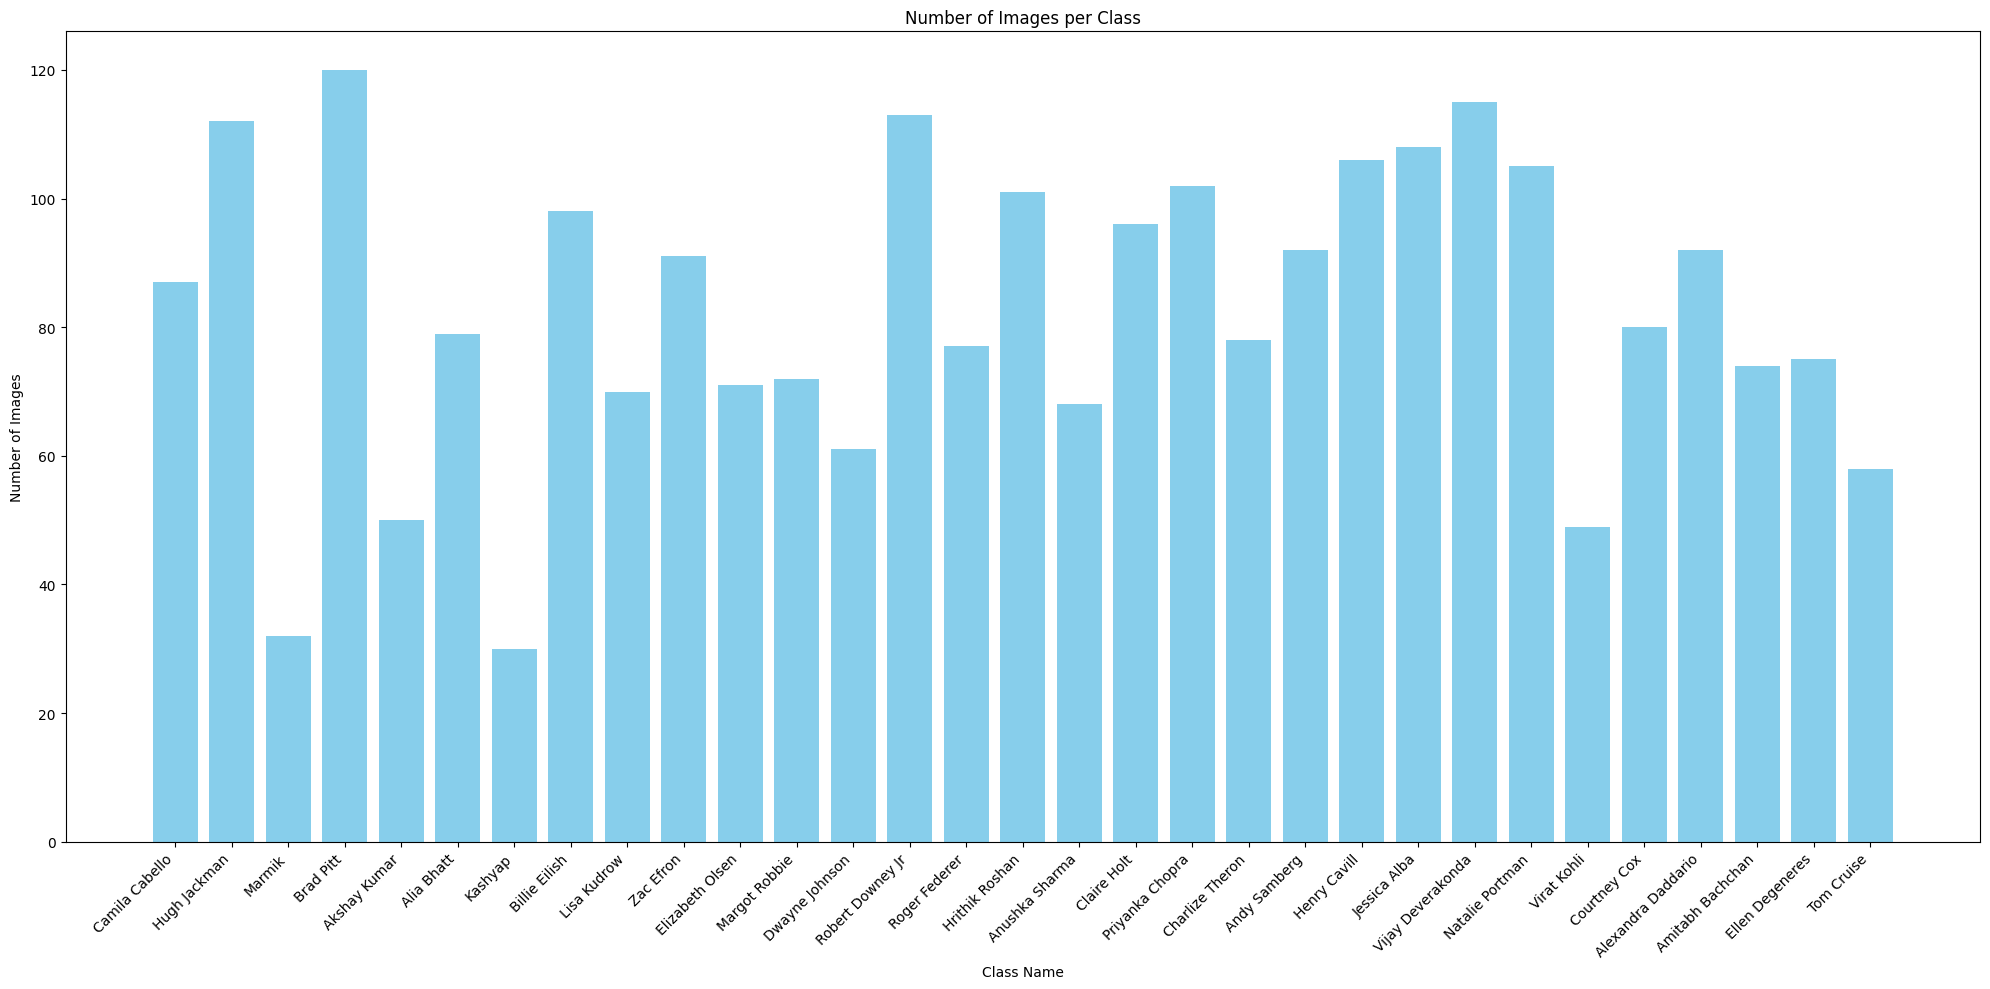

In [3]:
import os
import matplotlib.pyplot as plt


dataset_path = '/kaggle/working/organized_faces'


class_image_count = {}


for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    
    
    if os.path.isdir(class_dir):
        
        num_images = len([img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))])
        class_image_count[class_name] = num_images

num_classes = len(class_image_count)


print(f'Total number of classes: {num_classes}')

for class_name, num_images in class_image_count.items():
    print(f'Class "{class_name}": {num_images} images')


plt.figure(figsize=(20, 10))
plt.bar(class_image_count.keys(), class_image_count.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.tight_layout()  
plt.show()

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code>opservation</code>-> there are impalance in classes .
    </p>
</div>

In [ ]:
dataset_path = '/kaggle/working/organized_faces'

base_dir = '/kaggle/working/split_dataset'
train_dir = os.path.join(base_dir, 'train_dir')
test_dir = os.path.join(base_dir, 'test_dir')

for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)


def copy_images(image_paths, dest_folder):
    for img_path in image_paths:
        class_name = os.path.basename(os.path.dirname(img_path))
        class_folder = os.path.join(dest_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(img_path, class_folder)


def get_images_from_class(class_name):
    class_dir = os.path.join(dataset_path, class_name)
    images = []
    if os.path.isdir(class_dir):
        for entry in os.scandir(class_dir):
            if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append((entry.path, class_name))
    return images


all_images = []
all_labels = []

# Loop through all classes and collect images and labels
for class_name in os.listdir(dataset_path):
    images_in_class = get_images_from_class(class_name)
    all_images.extend([img_path for img_path, _ in images_in_class])
    all_labels.extend([label for _, label in images_in_class])


# Split data into  train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Copy images to respective directories
copy_images(train_images, train_dir)
copy_images(test_images, test_dir)

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 3 | </span><span style="color:#ff6200">Show some image</span></b></h2>

Displaying some images from train_images...


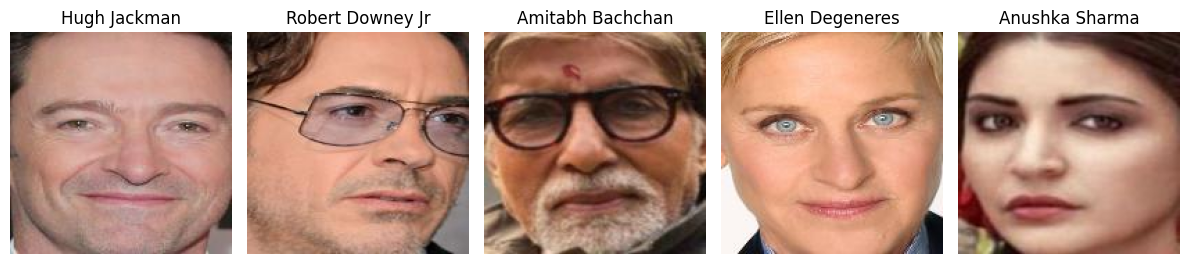

In [5]:
from PIL import Image  # Import the Image module from Pillow
import matplotlib.pyplot as plt

# Function to display some images
def display_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img = Image.open(image_paths[i])  # Open the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])  # Set the label as the title
    plt.tight_layout()
    plt.show()

# Display a few images from the virtual document set
print("Displaying some images from train_images...")
display_images(train_images, train_labels, num_images=5)


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 4 | </span><span style="color:#ff6200">Data Augmentation</span></b></h2>

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/kaggle/working/split_dataset/train_dir'
test_dir = '/kaggle/working/split_dataset/test_dir'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,          
    width_shift_range=0.2,      
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=0.2,              
    horizontal_flip=True,       
    fill_mode='nearest'          
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

Found 2049 images belonging to 31 classes.
Found 513 images belonging to 31 classes.


<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code>opservation</code>-> compute class weights .
    </p>
</div>

In [7]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))


print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.6524193548387096, 1: 0.8931996512641673, 2: 1.0491551459293396, 3: 1.120284308365227, 4: 0.8931996512641673, 5: 1.2240143369175627, 6: 0.847394540942928, 7: 0.688508064516129, 8: 0.9442396313364055, 9: 1.0660770031217481, 10: 0.8583996648512777, 11: 1.0327620967741935, 12: 1.348913759052008, 13: 1.1595925297113752, 14: 1.1016129032258064, 15: 0.7776091081593928, 16: 0.8160095579450418, 17: 0.7426603841971728, 18: 0.7685671417854464, 19: 2.754032258064516, 20: 1.180299539170507, 21: 1.139599555061179, 22: 2.542183622828784, 23: 0.7868663594470046, 24: 0.8160095579450418, 25: 0.7344086021505376, 26: 1.0660770031217481, 27: 1.4368863955119215, 28: 0.7184431977559608, 29: 1.694789081885856, 30: 0.9054352629253204}


<h2><b><span style="color:#005f26">🔶 Step 5 | </span><span style="color:#ff6200">Model</span></b></h2>



<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Resnet </font></span></h4>.

In [16]:
def residual_block(x, filters, kernel_size=3, stride=1, use_conv_shortcut=False):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if use_conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Combine shortcut and main path
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

In [17]:


def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, use_conv_shortcut=True)  # Downsampling
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, use_conv_shortcut=True)  # Downsampling
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, use_conv_shortcut=True)  # Downsampling
    x = residual_block(x, 512)

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Create model
    model = Model(inputs, outputs)
    return model


In [18]:
input_shape = (224, 224, 3) 
batch_size = 32

In [19]:
model = build_resnet(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# الكول باك لتحسين الأداء.
checkpoint = ModelCheckpoint("best_resnet.keras", monitor="val_loss", save_best_only=True, mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)

# تدريب النموذج
history = model.fit(
    train_generator,
    class_weight=class_weights_dict,
    validation_data=test_generator,
    epochs=50,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,206,815 (42.75 MB)

 Trainable params: 11,197,215 (42.71 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733969291.763324     125 service.cc:145] XLA service 0x7cd420004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733969291.763393     125 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733969291.763397     125 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/65 ━━━━━━━━━━━━━━━━━━━━ 25:50 24s/step - accuracy: 0.0625 - loss: 4.1181

I0000 00:00:1733969303.159754     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 53s 445ms/step - accuracy: 0.0721 - loss: 3.8871 - val_accuracy: 0.0117 - val_loss: 16.3440 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - accuracy: 0.1747 - loss: 2.8229 - val_accuracy: 0.0292 - val_loss: 9.3560 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 322ms/step - accuracy: 0.2515 - loss: 2.5229 - val_accuracy: 0.0390 - val_loss: 6.1375 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.2777 - loss: 2.3339 - val_accuracy: 0.0682 - val_loss: 5.1999 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.3203 - loss: 2.1635 - val_accuracy: 0.0721 - val_loss: 6.3968 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 321ms/step - accuracy: 0.3706 - loss: 2.0331 - val_accuracy: 0.2495 - val_loss: 3.5359 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.4206 - loss: 1.8026 - val

<h2><b><span style="color:#005f26">🔶 Step 7 | </span><span style="color:#ff6200">evaluation</span></b></h2>

Model saved to resnet_last.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8022 - loss: 0.6514
Validation Accuracy: 0.7894737124443054


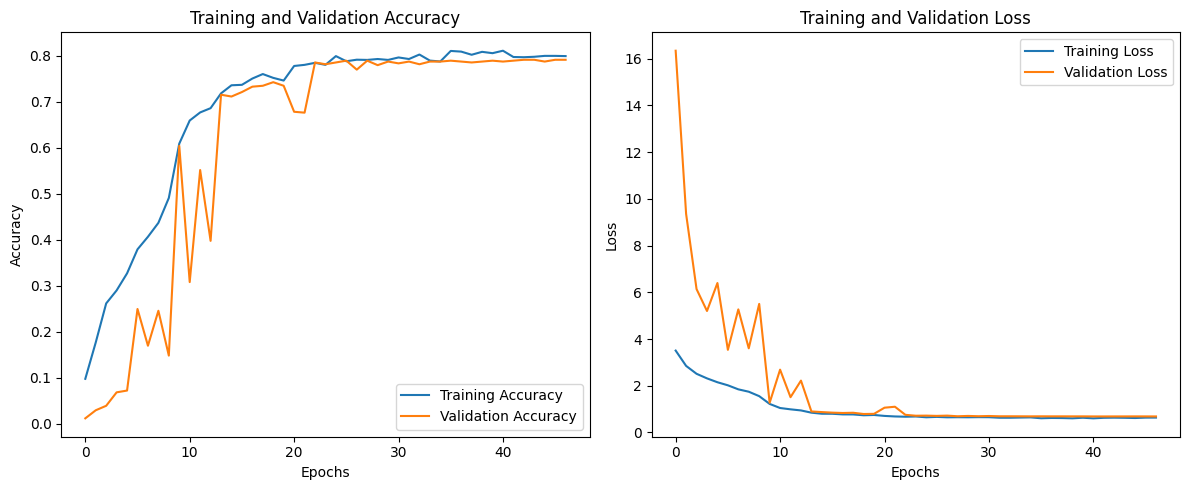

Model successfully loaded.


In [22]:
from tensorflow.keras.models import load_model
model_path = "resnet_last.h5"
modelresnet.save(model_path)
print(f"Model saved to {model_path}")

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy}")
# Plot training & validation accuracy and loss
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

# Load the saved model (to ensure it works properly)
loaded_model = load_model(model_path)
print("Model successfully loaded.")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step


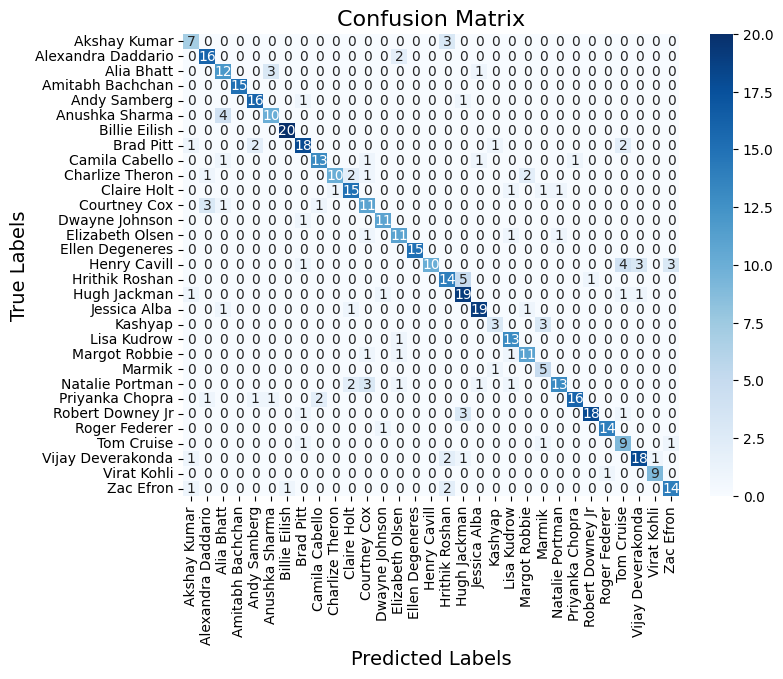

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.64      0.70      0.67        10
Alexandra Daddario       0.76      0.89      0.82        18
        Alia Bhatt       0.63      0.75      0.69        16
  Amitabh Bachchan       1.00      1.00      1.00        15
      Andy Samberg       0.84      0.89      0.86        18
    Anushka Sharma       0.71      0.71      0.71        14
     Billie Eilish       0.95      1.00      0.98        20
         Brad Pitt       0.78      0.75      0.77        24
    Camila Cabello       0.81      0.76      0.79        17
   Charlize Theron       0.91      0.62      0.74        16
       Claire Holt       0.75      0.79      0.77        19
      Courtney Cox       0.61      0.69      0.65        16
    Dwayne Johnson       0.85      0.92      0.88        12
   Elizabeth Olsen       0.69      0.79      0.73        14
   Ellen Degeneres       1.00      1.00      1.00        15
      Henry Cavi

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes for the validation set
y_pred_classes = model.predict(test_generator)  # Get predictions
y_pred_classes = np.argmax(y_pred_classes, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = test_generator.classes  # True class labels from the validation generator
class_labels = list(test_generator.class_indices.keys())  # Class names

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


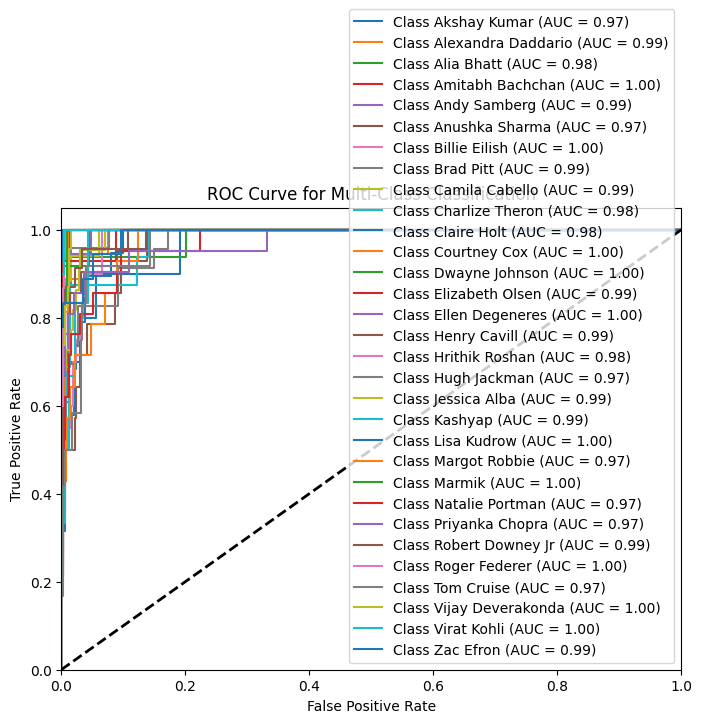

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


y_true = test_generator.classes  
y_prob = model.predict(test_generator)  


class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)


y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

<h2><b><span style="color:#005f26">🔶 Step 8 | </span><span style="color:#ff6200">make prediction </span></b></h2>

In [24]:
from keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = np.array(img) / 255.0  # Convert to NumPy array and normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image (optional)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Assuming you have 'model' and 'train_generator' defined elsewhere...
    # Predict the class
    pred = model.predict(img_array, batch_size=32)
    predicted_class_index = np.argmax(pred)

    # Reverse the mapping from class indices to class names
    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    # Get the actual class name from the file path
    actual_class = (image_path.split("/")[-1]).split("_")[0]

    # Display results
    print("Actual: " + actual_class)
    print("Predicted: " + f"{predicted_class_index} ({class_labels[predicted_class_index]})")

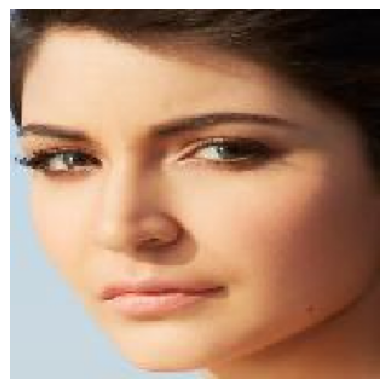

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: Anushka Sharma
Predicted: 5 (Anushka Sharma)


In [32]:
predict_image("/kaggle/working/split_dataset/test/Anushka Sharma/Anushka Sharma_19.jpg")

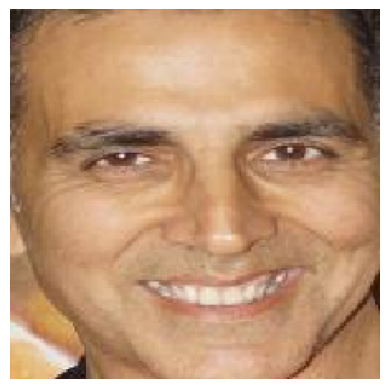

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Actual: Akshay Kumar
Predicted: 0 (Akshay Kumar)


In [26]:
predict_image("/kaggle/input/face-recognition-dataset/Faces/Faces/Akshay Kumar_24.jpg")


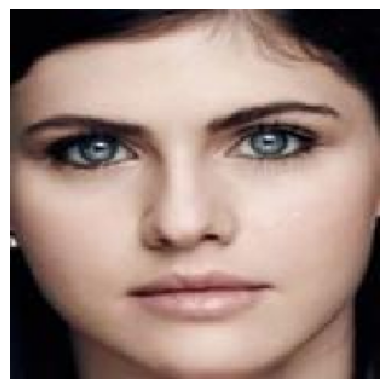

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Actual: Alexandra Daddario
Predicted: 1 (Alexandra Daddario)


In [27]:
predict_image("/kaggle/input/face-recognition-dataset/Faces/Faces/Alexandra Daddario_1.jpg")

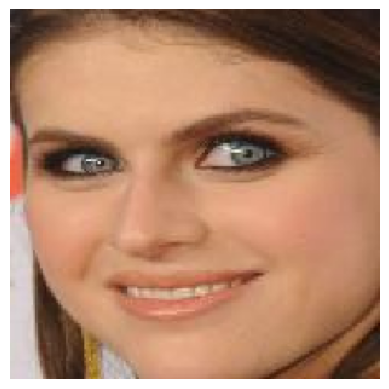

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: Alexandra Daddario
Predicted: 1 (Alexandra Daddario)


In [29]:
predict_image("//kaggle/working/split_dataset/test/Alexandra Daddario/Alexandra Daddario_11.jpg")